# Проверка гипотез для увличения выручки крупного интернет-магазина.

В нашем распоряжении данные о 9 гипотезах по по увеличению выручки интернет-магазина с параметрами Reach, Impact, Confidence, Effort, оцененными по 10-ти больной шкале. 

Также в файлах orders и visitors представленны данные о результатах A/B-теста.  

Цель проекта - провести приоритезацию гипотез для увеличения выручки интернет-магазина, запуск A/B-теста и анализ итогового результата.

Наша работа будет состоять из 5 шагов:

1. Загрузка данных
2. Предобработка данных
3. Приоритезация гипотез
4. Оценка A/B-теста
5. Общий вывод

В ходе A/B-теста мы изучим такие метики, как средний чек заказа и средее количесво заказов на посетителя. 

В итоге работы мы поймём в каком приоритете стоит проверять гипотезы, оценим результат A/B-теста и примим решение по его результатам: 
- Остановить тест, зафиксировать победу одной из групп.
- Остановить тест, зафиксировать отсутствие различий между группами.
- Продолжить тест.

## Загрузка данных и импорт необходимых библиотек.

In [1]:
#Импортируем все необходимые библиотеки.
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import scipy.stats as stats
from scipy import stats as st

# увеличим количество символов, которые можно показывать
pd.options.display.max_colwidth = 150
# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format
# задаем размер графика
sns.set(rc={'figure.figsize':(12,6)})

In [2]:
#прочитаем файлы с данными
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/datasets/hypothesis.csv'),
        pd.read_csv('/datasets/orders.csv'),
        pd.read_csv('/datasets/visitors.csv'))

except:
    hypothesis, orders, visitors = (
        pd.read_csv('hypothesis.csv'),
        pd.read_csv('orders.csv'),
        pd.read_csv('visitors.csv'))

## Предобработка данных.

In [3]:
#Откроем файл hypothesis.  
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
#Откроем файл orders.
orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [5]:
#Проверим на наличие пропусков и дубликатов 
display(orders.duplicated().sum())
orders.isna().sum()

0

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [6]:
#Откроем файл visitors.
visitors.info()
visitors

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [7]:
#Проверим на наличие пропусков и дубликатов 
display(visitors.duplicated().sum())
visitors.isna().sum()

0

date        0
group       0
visitors    0
dtype: int64

Дубликатов и пропусков в данных нет, изменим название столбцов в таблицах hypothesis и orders, приведем данные в столбце date к типу даты pandas в файлах visitors и orders. 

In [8]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

In [9]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [10]:
#Приведем столбец date к типу даты pandas в файле visitors
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [11]:
#Приведем столбец date к типу даты pandas в файле orders
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [12]:
# Посмотрим какое количество групп в А/В-тесте.
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [13]:
# Дата начала и окончания А/В теста. 
orders['date'].describe()

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

На А/В-тесте у нас 2 группы. Тестирование началось 2019-08-01 и закончилось 2019-08-31.

## Приоритезация гипотез.

- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [14]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

In [15]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Судя по расчетам метода ICE наиболее приоритетными гипотземи являются 8, 0 и 7. Они получили самые большие оценки.
Таким образом нам следует сначала Запустить акцию, дающую скидку на товар в день рождения(8), затем добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей(0) и добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок(7). 

Применим фреймворк RICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

In [16]:
hypothesis['RICE'] = (hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach'])/hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


Расчитав параметр RICE мы видим, что приоритезация гипотез поменялась. Наиболее приоритетными теперь являются гипоетзы под номером 7(добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок), 2(добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа) и 0(добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей). 
Метод RICE учитывает все те же параметры, что и ICE + учитывается на какое количество людей повлияет изменение. Так как 7 и 0 гипотеза также была в топ-3 в методе ICE. Нужно выбрать одну из них. 
Так как 7 гипотеза затронет значительно больше пользователей чем 0, выберем ёё. 

In [17]:
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.000


По итогу приоритезации нам следует сначала проверять 7-ю гипотезу: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

## Оценка A/B-теста.

### Создаём необходимый датафрейм. 

Для начала нам необходимо создать таблицу в токорой будет представлена информация о количестве посетителей, заказов, среднем чеке, группе и дате. 

In [18]:
# создаем массив уникальных пар значений дат и групп
dates_grouped = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [19]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [20]:
# объединяем данные в одной таблице и присваиваем ее столбцам понятные названия

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [21]:
# посчитаем также конверсию заказов от посетителей
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033
1,2019-08-01,B,21,20,101217,713,0.029
2,2019-08-02,A,44,38,242401,1338,0.033
3,2019-08-02,B,45,43,266748,1294,0.035
4,2019-08-03,A,68,62,354874,1845,0.037


In [22]:
# для проверки корректности датафрейма, посмотрим максимальную и минимальную дату. 
display(cumulative_data['date'].describe())
orders['date'].describe()

count                      62
unique                     31
top       2019-08-27 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Минимальная и максимальная даты в этом датафрейме совпадают с минимальной и максимальной датой в исходных данных. Значит датафлейм создан корректно. 

### Кумулятивные графики.

Теперь можем построить график кумулятивной выручки по группам. 

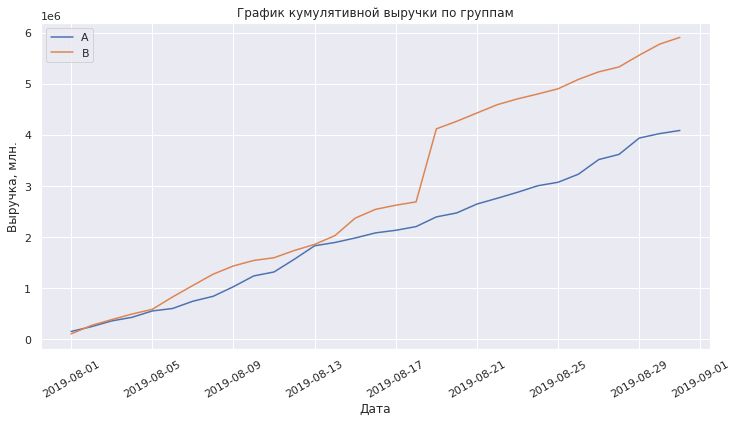

In [23]:
# датафрейм по группе А
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# датафрейм по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['revenue'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.ylabel("Выручка, млн.")
plt.xlabel("Дата")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Судя по графику клиенты группы A и B долгое время шли примерно на одном уровне по общей выручке с заказов. Обе группы имеют ростущий тренд. В середине Августа клиенты группы B начали показывать более высокую выручку, чем клиенты группы A. Возможно на это повлияли какие то дополнительные действия компании или просто люди из группы B совершили несколько крупных покупок что повлияло на всплеск выручки.

График кумулятивного среднего чека по группам.

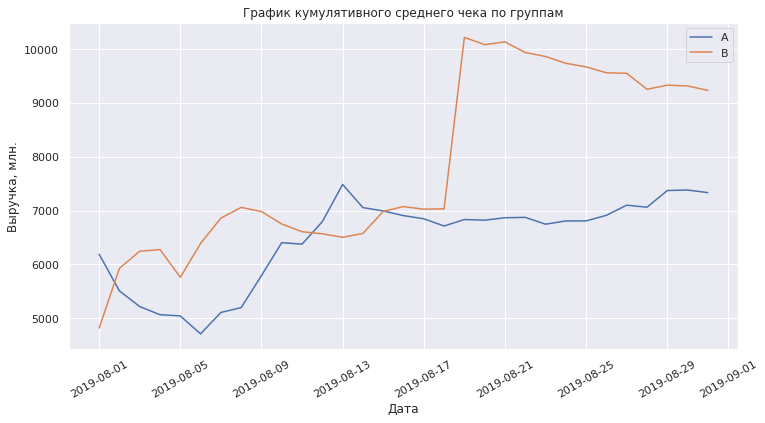

In [24]:
# датафрейм по группе А
avg_spend_a=cumulative_data_a['revenue']/cumulative_data_a['orders']

# датафрейм по группе B
avg_spend_b=cumulative_data_b['revenue']/cumulative_data_b['orders']

plt.plot(cumulative_data_a['date'], avg_spend_a, label='A')
plt.plot(cumulative_data_b['date'], avg_spend_b, label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel("Выручка, млн.")
plt.xlabel("Дата")
plt.xticks(rotation=30)
plt.legend()
plt.show()

В начале эксперемента мы видим, что средний чек у обоих групп имел нестабильный рост. В середине Августа мы также видим вссплеск среднего чека у группы В, что подтверждает нашу теорию о наличии аномально выскоких покупок.  

График относительного изменения кумулятивного среднего чека группы B к группе A.

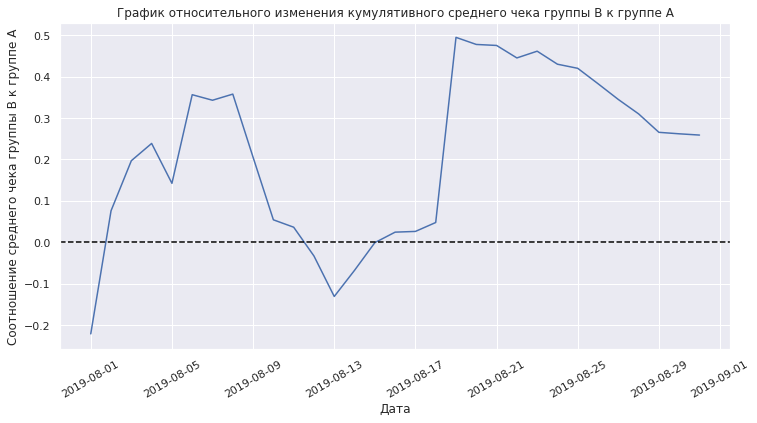

In [25]:
# соединим данные по коммулитивной выручки в одном датафрейме
cumulative_data_ab = cumulative_data_a.merge(
    cumulative_data_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# cтроим отношение средних чеков
plt.plot(cumulative_data_ab['date'], 
         (
             cumulative_data_ab['revenue_b']/cumulative_data_ab['orders_b']
         )/
         (
             cumulative_data_ab['revenue_a']/cumulative_data_ab['orders_a']
         )-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.ylabel("Соотношение среднего чека группы B к группе A")
plt.xlabel("Дата")
plt.xticks(rotation=30)
plt.show()

На протяжении всего эксперемента график неравномен, значит средний чек у двух групп не зависим. В каждой группе быват дни, когда средний чек значительно выше чем у другой группы. Возможно данные скачки связаны с непостоянным средним чеком. Как показывают предыдущие графики средний чек менялся на протяжении всего периода, поэтому и соотношение среднего чека группы B к группе A сильно скачет. 

График кумулятивного среднего количества заказов на посетителя по группам.

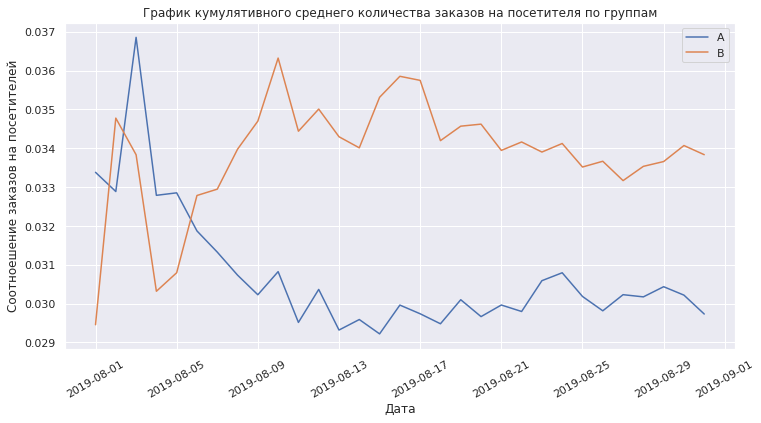

In [26]:
# датафрейм по группе А
avg_order_a=cumulative_data_a['orders']/cumulative_data_a['visitors']

# датафрейм по группе B
avg_order_b=cumulative_data_b['orders']/cumulative_data_b['visitors']

plt.plot(cumulative_data_a['date'], avg_order_a, label='A')
plt.plot(cumulative_data_b['date'], avg_order_b, label='B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel("Соотноешение заказов на посетителей")
plt.xlabel("Дата")
plt.xticks(rotation=30)
plt.legend()
plt.show()

В начале мы видим нествбильное состояние графика, но уже 9 Августа графики успокоились и показывали среднее количество заказов на посетителя более равномерно. Однако, мы можем заметить что соотношение среднего количество заказов на посетителя гораздо лучше у группы B. 

График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

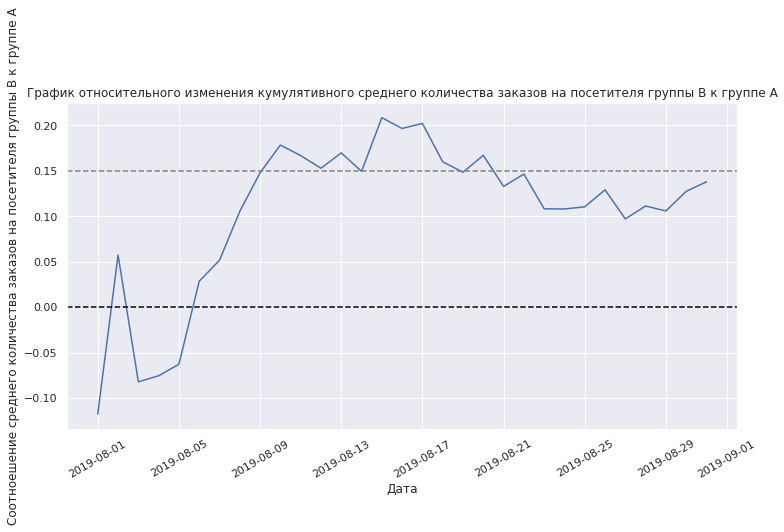

In [27]:
plt.plot(
    cumulative_data_ab['date'], 
    cumulative_data_ab['conversion_b']/
    cumulative_data_ab['conversion_a']-1
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.ylabel("Соотноешение среднего количества заказов на посетителя группы B к группе A")
plt.xlabel("Дата")
plt.xticks(rotation=30)

plt.show()

В начале эксперемента группа В проигрывала группе А, но потом все поменялось. Сначала количество заказов на пользователя из группы B росла, потом спадала и сейчас опять растет.

### Распределение по пользователям.

Точечный график количества заказов по пользователям.

count   1,031.000
mean        1.161
std         0.725
min         1.000
25%         1.000
50%         1.000
75%         1.000
max        11.000
Name: orders, dtype: float64

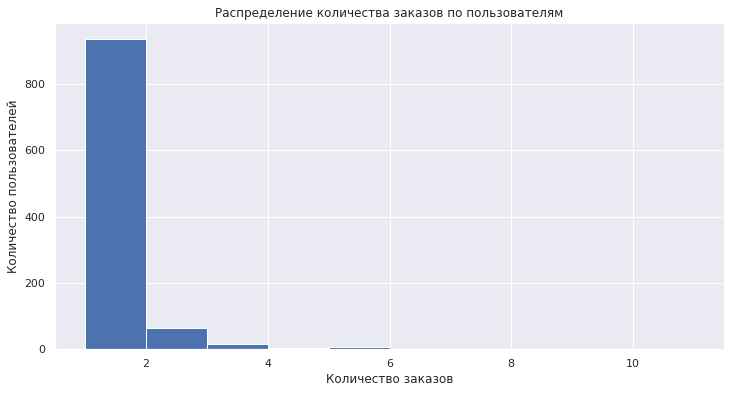

In [28]:
# посчитаем распределение количества заказов по пользователям
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']
display(orders_by_users['orders'].describe())

# строим гистограмму
plt.hist(orders_by_users['orders']) 
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

Как мы видим на диаграмме в основном пользователи делали по 1-2 заказа за период всего эксперемента. Также есть пользователь который сделал 11 заказов за период. 

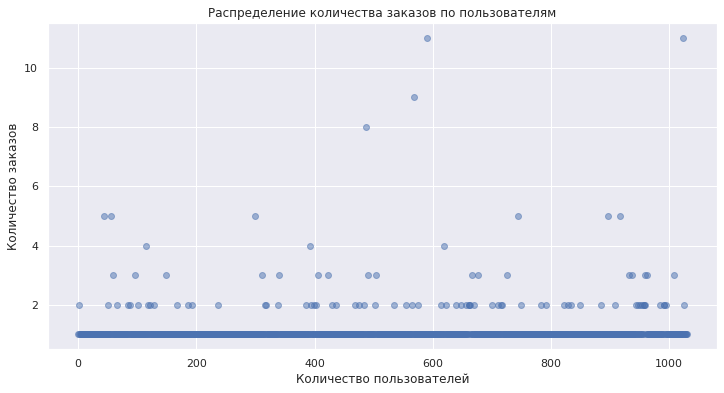

In [29]:
x_values = pd.Series(range(0,len(orders_by_users)))

# построим точечную диаграмму
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5)
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
plt.show()

Судя по точечной диаграмме, большенство пользователей делают один заказ, далее идет группа пользователей которые сделали 2 заказа за период. Две эти группы самые многочисленные. 

Посчитатем 95-й и 99-й перцентили количества заказов на пользователя.

In [30]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

5% пользователей совершали больше 2-х покупок за время эксперимента. И только 1% сделали четыре и более заказа.
Примем за верхнюю границу 4 заказа на одного пользователя.

Точечный график стоимостей заказов.

count       1,197.000
mean        8,348.006
std        39,191.132
min            50.000
25%         1,220.000
50%         2,978.000
75%         8,290.000
max     1,294,500.000
Name: revenue, dtype: float64

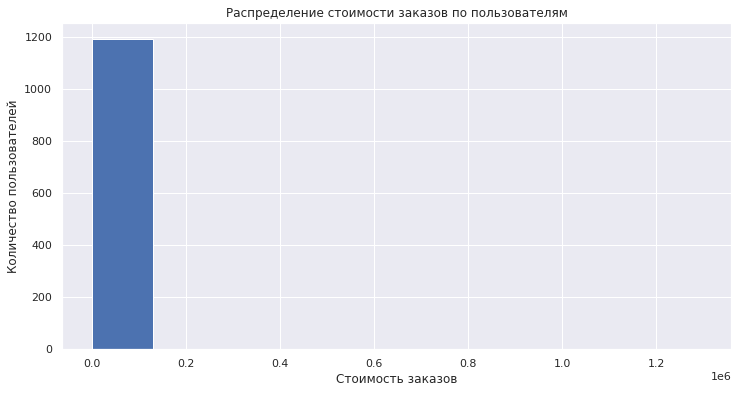

In [31]:
display(orders['revenue'].describe())

# строим гистограмму
plt.hist(orders['revenue']) 
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.show()

Средняя стоимость в основном составляет 8 348 у.е. Минимальная стомость 50 у.е., максимальная - 1 294 500. Видимо этот заказ и повлиял на всплеск на графиках группы В. 

In [32]:
#посмотрим с какой группы был сделан заказ на сумму более 100 000. 
max_revenue = orders[orders['revenue'] > 100000]
max_revenue

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


Наши догадки позтвердились, самые дорогие заказы были сделаны именно в группе B, что и объясняет значительный скачок на предыдущих графиках. 

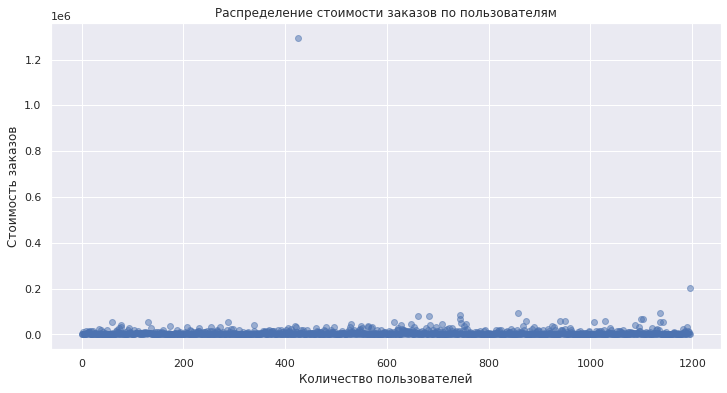

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# строим точечную диаграмму
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

Самые дорогие заказы следует удалить, чтобы детальней посмотреть распределение стоимости заказов на пользователей. 

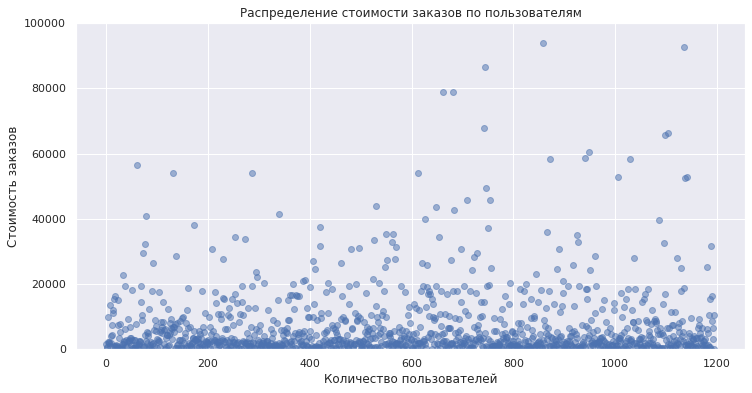

In [34]:
# строим точечную диаграмму
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

Теперь мы видим, что больщая часть людей делает покупки на сумму до 20 000 у.е. 

95-й и 99-й перцентили стоимости заказов.

In [35]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


5% покупателей совершили заказы на сумму более чем 28 000, лишь 1% людей совершили заказы более 58 233.  Опредилим границу на верхнем уровне. 

### Статистическая значимость.

Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Посчитаем статистическую значимость различий в конверсии между группами без удаления аномальных пользователей.

Гипотеза: различий в среднем количестве заказов на посетителя между группами по «сырым» данным нет. 

α = 0,05


Для проверки гипотезы мы будем использовать тест Уилкоксона-Манна-Уитни. 
Но для начала подготовим наши данные.

In [36]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

data.head()

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Мы получили таблицу с датами и параметрами для каждой группы: количество заказов в день, итоговая выручка за день, количество посетителей в день, количество заказов до указанного дня, итоговая выручка по заказом до указанного дня и количество клиентов до указанного дня. 

Далее посчитаем количество заказов по каждому клиенту, совершивший хотя бы один заказ, для двух групп. 

In [37]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [38]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )

Задаем функцию, для проверки гипотезы

In [39]:
# Функция для проверки гипотезы о равенстве групп data A и data B
def stat_significance(data_a, data_b):
    alpha = 0.05 #устанавсливаем уровень значисости 
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем гипотезу: между группами есть разница")
    else:
        print("Не получилось отвергнуть гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))

In [40]:
stat_significance(sample_a, sample_b)

P-value: 0.017
Отвергаем гипотезу: между группами есть разница
Относительный прирост В к А: 13.808%


По результатам тестирования мы отвергаем нашу гипотезу, между группами А и В есть разница в среднем количестве заказов на посетителя. 

Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Гипотеза: различий в среднем чеке между группами по «сырым» данным нет.

α = 0,05 

In [41]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.729
Не получилось отвергнуть гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


По результатам теста гипотеза не отвергается, значит различий в среднем чеке между группами по «сырым» данным нет.

Однако мы можем заметить, что средний чек группы B значительно выше среднего чека группы A.

Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Как мы определили раннее, аномальные пользователи будут те, кто совершил больше 4 заказов или сумма заказа был более 58233.
Так мы уберём 1% пользователей с наибольшим числом заказов и 1% пользователей с самыми дорогими заказами.

In [42]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

У нас получилост 15 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста, для этого подготовим наши данные. 

In [43]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


In [44]:
stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.014
Отвергаем гипотезу: между группами есть разница
Относительный прирост В к А: 15.331%


На очищенных данных разница в конверсии между группами есть, а относительный прирост конверсии группы В отнистельно группы А увеличился на 15.3%.

Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [45]:
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
                  )

P-value: 0.851
Не получилось отвергнуть гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.575%


Гипотеза не отвергается, значит в среднем чеке нет различий между группами.

### Итоговое решение.

Мы провели проверку гипотез, которые показали, что у группы В больше среднее количество заказов на постителя.
По результатам тестирования нам следует остановить тест, зафиксировать победу группы В.

## Общий вывод.

В данном исследовании провели предобработку данных, приоритезацию гипотез и анализ А/В тестов. 

Во время предобработки данных мы изменили название столбцов в таблицах hypothesis и orders, а также привели данные в столбце date к типу даты pandas в файлах visitors и orders.

Приоритезация гипотез показала, что в первую очередь нужно проверять 7-ю гипотезу: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Данная гипотеза наименее трудозатратна, наиболее сильно повлияет на результат и затронет большее количество клиентов. 

В ходе анализа мы установили:

- Клиенты группы A и B изначально были на одном уровне по общей выручке с заказов, однако под конец эксперимента группа В показывала больее лучшие результаты.
- В начале эксперемента средний чек у обоих групп имел нестабильный рост. В середине Августа мы также видим значительный всплеск среднего чека у группы В.
- Средний чек у двух групп не зависим друг от друга. 
- Соотношение среднего количество заказов на посетителя лучше у группы B, чем у группы А. 
- Большенство пользователей сделали 1-2 заказа за период эксперимента. Максимальное количество заказов - 11.
- Средняя стоимость заказа составляет 8 348 у.е. Минимальная стомость 50 у.е., максимальная - 1 294 500. Самые дорогие заказы были сделаны в группе B, что и объясняет значительный скачок среднего чека и всплеск общей выручки у группы B.

По результату А/В тестирования мы сделали выводы:

- Гипотеза, что различий в среднем количестве заказов на посетителя между группами нет отверглась, как до удаление аномалий, так и после. Конверсия группы В выше, чем в А, на 13%-15%.

- Гипотеза, что различий в среднем чеке между группами нет подтвердилась, как до удаление аномалий, так и после. 

На оснавании вышеизложенных фактов мы решили остановить тестирование, зафиксировать победу группы В.